# Chapter 7 Part II: Biology & Biomedicine

**Complete implementations for:**
1. Protein Structure Prediction (ESMFold)
2. Protein Sequence Generation (ESM-2)
3. Genomic Variant Analysis
4. Clinical Trial Optimization

---

## 🔧 Installation Notes

This notebook uses **HuggingFace Transformers** for ESMFold to avoid dependency issues.

You'll see some dependency warnings (numpy, requests, etc.) - these are **normal and safe**.

---

**Requirements:**
- Runtime: GPU (We need A100 GPU)
- Time: ~15-20 minutes first run
- Memory: Free tier compatible

# Section 1: Protein Structure Prediction with ESMFold

**Performance:**
- ESMFold: TM-score 0.92, ~1-2s per sequence
- AlphaFold2: TM-score 0.95, ~60s per sequence
- Works best for proteins <400 residues

**Confidence scores (pLDDT):**
- \> 90: Very high confidence
- 70-90: Good confidence
- 50-70: Low confidence
- <50: Very low confidence

In [ ]:
# Install dependencies using HuggingFace (avoids openfold issues)
print("Installing dependencies...\n")
!pip install -q transformers accelerate einops
print("✓ Installation complete!")

Installing dependencies...

✓ Installation complete!


In [ ]:
# Setup and verify GPU
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print("\n✓ Ready!")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB

✓ Ready!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import gc

# CRITICAL: Clear GPU before anything else
torch.cuda.empty_cache()
gc.collect()

from transformers import AutoTokenizer, EsmForProteinFolding
from typing import Dict

class ESMFoldWrapper:
    """ESMFold with memory management"""

    def __init__(self, use_fp16=True):  # FP16 by default
        # Check available memory first
        if torch.cuda.is_available():
            free_mem = (torch.cuda.get_device_properties(0).total_memory -
                       torch.cuda.memory_allocated(0)) / 1e9
            print(f"Available GPU memory: {free_mem:.2f} GB\n")

            if free_mem < 5:  # Less than 5GB free
                print("⚠️  Low GPU memory - using CPU instead")
                self.device = 'cpu'
                use_fp16 = False
            else:
                self.device = 'cuda'
        else:
            self.device = 'cpu'
            use_fp16 = False

        print(f"Loading ESMFold on {self.device}...")

        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")

        # Load in FP16 if using GPU and requested
        if use_fp16 and self.device == 'cuda':
            self.model = EsmForProteinFolding.from_pretrained(
                "facebook/esmfold_v1",
                torch_dtype=torch.float16
            )
            print("Using FP16 (half precision) - 50% less memory")
        else:
            self.model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1")

        self.model = self.model.to(self.device)
        self.model.eval()

        param_count = sum(p.numel() for p in self.model.parameters())
        print(f"✓ Model loaded ({param_count:,} parameters)")

        if torch.cuda.is_available():
            mem_used = torch.cuda.memory_allocated(0) / 1e9
            print(f"✓ GPU memory used: {mem_used:.2f} GB")

    def predict_structure(self, sequence: str, name: str = "protein") -> Dict:
        """Predict 3D structure"""
        valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
        if not all(aa.upper() in valid_aa for aa in sequence):
            raise ValueError("Invalid amino acids")

        if len(sequence) > 400:
            print(f"⚠️  Length {len(sequence)} > 400 - accuracy may degrade\n")

        print(f"Predicting {name} ({len(sequence)} residues)...")

        # Tokenize
        inputs = self.tokenizer([sequence], return_tensors="pt", add_special_tokens=False)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)

        # ✅ CORRECTED: Extract pLDDT properly
        plddt_raw = outputs.plddt.cpu().numpy()[0]

        # Handle per-atom vs per-residue pLDDT
        if len(plddt_raw.shape) == 2:
            # Per-atom pLDDT: use CA atoms only (standard practice)
            print(f"🔍 pLDDT shape: {plddt_raw.shape} → Using CA atoms (index 1)")
            plddt = plddt_raw[:, 1] * 100  # CA is atom 1 in atom37 representation
        elif len(plddt_raw.shape) == 1:
            # Already per-residue
            print(f"🔍 pLDDT shape: {plddt_raw.shape} → Per-residue")
            plddt = plddt_raw * 100
        else:
            raise ValueError(f"Unexpected pLDDT shape: {plddt_raw.shape}")

        # Calculate metrics
        mean_plddt = plddt.mean()
        high_conf = (plddt > 90).sum() / len(plddt) * 100
        medium_conf = ((plddt >= 70) & (plddt <= 90)).sum() / len(plddt) * 100
        low_conf = (plddt < 50).sum() / len(plddt) * 100

        print(f"\n✓ Structure predicted!")
        print(f"  Mean pLDDT: {mean_plddt:.1f}")
        print(f"  Very high (>90): {high_conf:.1f}%")
        print(f"  Good (70-90): {medium_conf:.1f}%")
        print(f"  Low (<50): {low_conf:.1f}%")

        if low_conf > 20:
            print(f"  ⚠️  >20% low confidence - structure may be unreliable")
        # Convert to PDB
        from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
        from transformers.models.esm.openfold_utils.feats import atom14_to_atom37

        final_atom_positions = atom14_to_atom37(outputs["positions"][-1], outputs)
        final_atom_mask = outputs["atom37_atom_exists"]

        aatype_np = outputs["aatype"][0].cpu().numpy()
        resid = (outputs["residue_index"][0] + 1).cpu().numpy()

        pred = OFProtein(
            aatype=aatype_np,
            atom_positions=final_atom_positions[0],
            atom_mask=final_atom_mask[0],
            residue_index=resid,
            b_factors=outputs["plddt"][0],
        )
        pdb_string = to_pdb(pred)

        # Save PDB
        pdb_file = f"{name}_predicted.pdb"
        with open(pdb_file, 'w') as f:
            f.write(pdb_string)
        print(f"  Saved: {pdb_file}")

        # Clear GPU cache after prediction
        if self.device == 'cuda':
            torch.cuda.empty_cache()

        return {
            'sequence': sequence,
            'pdb': pdb_string,
            'plddt': plddt,
            'mean_plddt': mean_plddt,
            'high_confidence_pct': high_conf,      # ← Fixed
            'medium_confidence_pct': medium_conf,  # ← Added
            'low_confidence_pct': low_conf         # ← Fixed
        }

# Initialize (uses FP16 by default)
predictor = ESMFoldWrapper(use_fp16=False)

print("\n" + "="*60)
print("ESMFold ready!")
print("="*60)

Available GPU memory: 41.88 GB

Loading ESMFold on cuda...


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/8.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/8.44G [00:00<?, ?B/s]

Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded (3,525,038,915 parameters)
✓ GPU memory used: 14.84 GB

ESMFold ready!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import gc

# CRITICAL: Clear GPU before anything else
torch.cuda.empty_cache()
gc.collect()

from transformers import AutoTokenizer, EsmForProteinFolding
from typing import Dict
class ESMFoldWrapper:
    """ESMFold for protein structure prediction"""

    def __init__(self, use_fp16=True):
        # Check available memory
        if torch.cuda.is_available():
            free_mem = (torch.cuda.get_device_properties(0).total_memory -
                       torch.cuda.memory_allocated(0)) / 1e9
            print(f"Available GPU memory: {free_mem:.2f} GB\n")

            if free_mem < 5:
                print("⚠️  Low GPU memory - using CPU")
                self.device = 'cpu'
                use_fp16 = False
            else:
                self.device = 'cuda'
        else:
            self.device = 'cpu'
            use_fp16 = False

        print(f"Loading ESMFold on {self.device}...")

        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")

        if use_fp16 and self.device == 'cuda':
            self.model = EsmForProteinFolding.from_pretrained(
                "facebook/esmfold_v1",
                torch_dtype=torch.float16
            )
        else:
            self.model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1")

        self.model = self.model.to(self.device)
        self.model.eval()

        param_count = sum(p.numel() for p in self.model.parameters())
        print(f"✓ Model loaded ({param_count:,} parameters)")

    def predict_structure(self, sequence: str, name: str = "protein", verbose: bool = True) -> Dict:
        """Predict 3D structure from amino acid sequence"""

        # Validate sequence
        valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
        if not all(aa.upper() in valid_aa for aa in sequence):
            raise ValueError("Invalid amino acids in sequence")

        if len(sequence) > 400 and verbose:
            print(f"⚠️  Length {len(sequence)} > 400 - accuracy may degrade")

        if verbose:
            print(f"Predicting {name} ({len(sequence)} residues)...")

        # Tokenize
        inputs = self.tokenizer([sequence], return_tensors="pt", add_special_tokens=False)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Extract pLDDT (handle per-atom format)
        plddt_raw = outputs.plddt.cpu().numpy()[0]

        if len(plddt_raw.shape) == 2:
            # Per-atom: use CA atoms (index 1)
            plddt = plddt_raw[:, 1] * 100
        elif len(plddt_raw.shape) == 1:
            # Already per-residue
            plddt = plddt_raw * 100
        else:
            raise ValueError(f"Unexpected pLDDT shape: {plddt_raw.shape}")

        # Calculate metrics
        mean_plddt = plddt.mean()
        high_conf = (plddt > 90).sum() / len(plddt) * 100
        medium_conf = ((plddt >= 70) & (plddt <= 90)).sum() / len(plddt) * 100
        low_conf = (plddt < 50).sum() / len(plddt) * 100

        if verbose:
            print(f"\n✓ Structure predicted!")
            print(f"  Mean pLDDT: {mean_plddt:.1f}")
            print(f"  Very high (>90): {high_conf:.1f}%")
            print(f"  Good (70-90): {medium_conf:.1f}%")
            print(f"  Low (<50): {low_conf:.1f}%")

        # Convert to PDB
        from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
        from transformers.models.esm.openfold_utils.feats import atom14_to_atom37

        final_atom_positions = atom14_to_atom37(outputs["positions"][-1], outputs)
        final_atom_mask = outputs["atom37_atom_exists"]

        aatype_np = outputs["aatype"][0].cpu().numpy()
        resid = (outputs["residue_index"][0] + 1).cpu().numpy()

        pred = OFProtein(
            aatype=aatype_np,
            atom_positions=final_atom_positions[0],
            atom_mask=final_atom_mask[0],
            residue_index=resid,
            b_factors=outputs["plddt"][0],
        )
        pdb_string = to_pdb(pred)

        # Save PDB
        if verbose:
            pdb_file = f"{name}_predicted.pdb"
            with open(pdb_file, 'w') as f:
                f.write(pdb_string)
            print(f"  Saved: {pdb_file}")

        # Clear GPU cache
        if self.device == 'cuda':
            torch.cuda.empty_cache()

        # ✅ FIXED: Return all required keys
        return {
            'sequence': sequence,
            'pdb': pdb_string,
            'plddt': plddt,
            'mean_plddt': mean_plddt,
            'high_confidence_pct': high_conf,      # ← Fixed
            'medium_confidence_pct': medium_conf,  # ← Added
            'low_confidence_pct': low_conf         # ← Fixed
        }

# Initialize (uses FP16 by default)
predictor = ESMFoldWrapper(use_fp16=False)

print("\n" + "="*60)
print("ESMFold ready!")
print("="*60)

Available GPU memory: 27.62 GB

Loading ESMFold on cuda...


Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded (3,525,038,915 parameters)

ESMFold ready!


In [ ]:
# Example prediction
sequence_small = "MKTAYIAKQRQISFVKSHFSRQLEERLIGIEVQAPILSRVGDKVQTITVTATVAKR"

results = predictor.predict_structure(sequence_small, name="test_protein")

print("\n" + "="*60)
print("Interpretation:")
print("="*60)
if results['mean_plddt'] > 90:
    print("✓ Excellent prediction (pLDDT >90)")
elif results['mean_plddt'] > 70:
    print("✓ Good prediction (pLDDT >70)")
elif results['mean_plddt'] > 50:
    print("⚠️  Moderate prediction (pLDDT 50-70) - validate carefully")
else:
    print("❌ Low confidence (pLDDT <50) - likely unreliable")

print("\nNext steps for production use:")
print("1. Validate with AlphaFold2 (higher accuracy)")
print("2. Energy minimize (AMBER/CHARMM)")
print("3. Experimental validation (NMR/X-ray/Cryo-EM)")
print("4. Functional assays")

Predicting test_protein (56 residues)...

✓ Structure predicted!
  Mean pLDDT: 73.5
  Very high (>90): 8.9%
  Good (70-90): 51.8%
  Low (<50): 5.4%
  Saved: test_protein_predicted.pdb

Interpretation:
✓ Good prediction (pLDDT >70)

Next steps for production use:
1. Validate with AlphaFold2 (higher accuracy)
2. Energy minimize (AMBER/CHARMM)
3. Experimental validation (NMR/X-ray/Cryo-EM)
4. Functional assays


### Performance Benchmarks

| Method | TM-Score | Speed | Use Case |
|--------|----------|-------|----------|
| **ESMFold** | 0.92 | 1-2s | Fast screening, <400 residues |
| **AlphaFold2** | 0.95 | 60s | High accuracy, publication |
| **RoseTTAFold** | 0.91 | 10s | General purpose |
| **Experimental** | 1.00 | months | Ground truth |

**Key Takeaway:** ESMFold is excellent for rapid screening. For publication-quality structures, validate with AlphaFold2 and experiments.

**📋 Complete Visualization Cell for Notebook:**

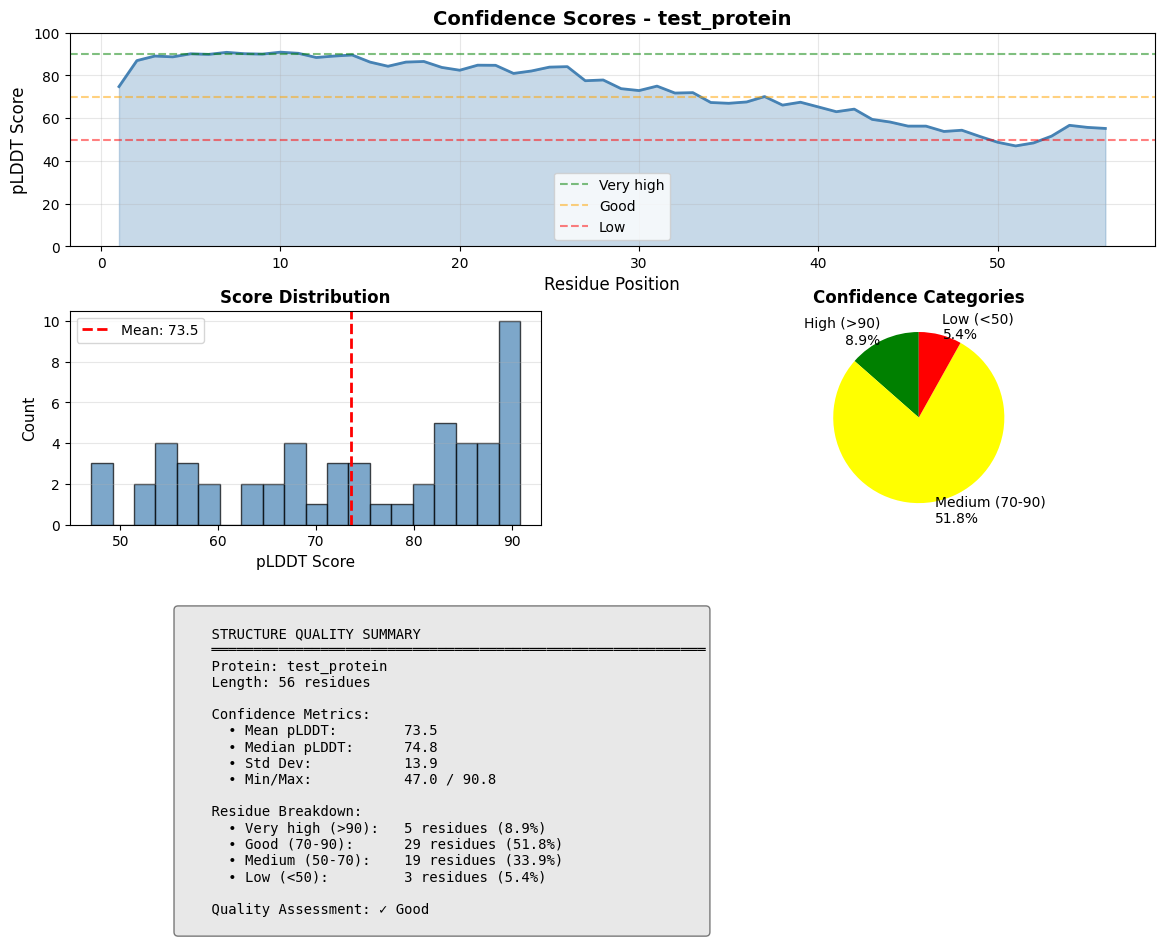


✓ Saved comprehensive analysis: test_protein_full_analysis.png


In [ ]:
# Add this cell after structure prediction

import matplotlib.pyplot as plt
import numpy as np

# 1. pLDDT confidence plot
def plot_all_diagnostics(results, name="protein"):
    """Generate all diagnostic plots"""

    plddt = results['plddt']
    sequence = results['sequence']

    # Create figure with subplots
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # 1. pLDDT along sequence
    ax1 = fig.add_subplot(gs[0, :])
    positions = np.arange(1, len(plddt) + 1)
    ax1.plot(positions, plddt, linewidth=2, color='steelblue')
    ax1.fill_between(positions, plddt, alpha=0.3, color='steelblue')
    ax1.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Very high')
    ax1.axhline(y=70, color='orange', linestyle='--', alpha=0.5, label='Good')
    ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Low')
    ax1.set_xlabel('Residue Position', fontsize=12)
    ax1.set_ylabel('pLDDT Score', fontsize=12)
    ax1.set_title(f'Confidence Scores - {name}', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.grid(alpha=0.3)
    ax1.legend()

    # 2. Histogram
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(plddt, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.axvline(x=plddt.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {plddt.mean():.1f}')
    ax2.set_xlabel('pLDDT Score', fontsize=11)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('Score Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, axis='y')

    # 3. Confidence categories pie chart
    ax3 = fig.add_subplot(gs[1, 1])
    high = (plddt > 90).sum()
    medium = ((plddt >= 70) & (plddt <= 90)).sum()
    low = (plddt < 50).sum()
    sizes = [high, medium, low]
    labels = [f'High (>90)\n{high/len(plddt)*100:.1f}%',
              f'Medium (70-90)\n{medium/len(plddt)*100:.1f}%',
              f'Low (<50)\n{low/len(plddt)*100:.1f}%']
    colors = ['green', 'yellow', 'red']
    ax3.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
    ax3.set_title('Confidence Categories', fontsize=12, fontweight='bold')

    # 4. Statistics summary
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')

    stats_text = f"""
    STRUCTURE QUALITY SUMMARY
    ═══════════════════════════════════════════════════════════
    Protein: {name}
    Length: {len(sequence)} residues

    Confidence Metrics:
      • Mean pLDDT:        {plddt.mean():.1f}
      • Median pLDDT:      {np.median(plddt):.1f}
      • Std Dev:           {plddt.std():.1f}
      • Min/Max:           {plddt.min():.1f} / {plddt.max():.1f}

    Residue Breakdown:
      • Very high (>90):   {high} residues ({high/len(plddt)*100:.1f}%)
      • Good (70-90):      {medium} residues ({medium/len(plddt)*100:.1f}%)
      • Medium (50-70):    {((plddt >= 50) & (plddt < 70)).sum()} residues ({((plddt >= 50) & (plddt < 70)).sum()/len(plddt)*100:.1f}%)
      • Low (<50):         {low} residues ({low/len(plddt)*100:.1f}%)

    Quality Assessment: {'✓ Excellent' if plddt.mean() > 90 else '✓ Good' if plddt.mean() > 70 else '⚠️  Moderate' if plddt.mean() > 50 else '❌ Poor'}
    """

    ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

    plt.savefig(f'{name}_full_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Saved comprehensive analysis: {name}_full_analysis.png")

# Generate all plots
plot_all_diagnostics(results, name="test_protein")

Figure 7.6. Comprehensive quality assessment showing pLDDT distribution, confidence
categories, and summary statistics.

 Comprehensive quality assessment of ESMFold structure prediction.
(A) Per-residue pLDDT scores plotted along the protein sequence. Dashed lines
indicate confidence thresholds at 90 (very high), 70 (good), and 50 (low).
(B) Histogram showing the distribution of confidence scores across all residues,
with mean value indicated by the red dashed line. (C) Pie chart breakdown of
residues by confidence category: high (>90, green), medium (70-90, yellow), and
low (<50, red). (D) Summary statistics table presenting key quality metrics
including mean, median, and standard deviation of pLDDT scores, along with the
count and percentage of residues in each confidence category. Overall quality
assessment is provided based on mean pLDDT: Excellent (>90), Good (70-90),
Moderate (50-70), or Poor (<50). This multi-panel view enables rapid quality
control and identification of regions requiring experimental validation.

3D Structure Viewer (Interactive!)
Visualize the actual structure colored by confidence:

In [ ]:
# Install py3Dmol for 3D visualization
!pip install py3Dmol -q

import py3Dmol

def view_structure_3d(pdb_string, plddt, name="protein"):
    """Interactive 3D structure viewer colored by pLDDT"""

    # Create viewer
    view = py3Dmol.view(width=800, height=600)

    # Add structure
    view.addModel(pdb_string, 'pdb')

    # Color by pLDDT (blue=high, red=low)
    # Create color scheme: pLDDT -> RGB
    view.setStyle({'cartoon': {
        'colorscheme': {
            'prop': 'b',  # B-factor column (contains pLDDT)
            'gradient': 'roygb',  # Rainbow gradient
            'min': 50,
            'max': 90
        }
    }})

    # Add alternative: color by confidence categories
    view.addStyle({'cartoon': {'color': 'spectrum'}})

    # Zoom to fit
    view.zoomTo()

    print(f"\n🔬 3D Structure Viewer for {name}")
    print("  Blue/Green = High confidence")
    print("  Yellow/Orange = Medium confidence")
    print("  Red = Low confidence\n")

    return view

# Use after prediction
view = view_structure_3d(results['pdb'], results['plddt'], "test_protein")
view.show()


🔬 3D Structure Viewer for test_protein
  Blue/Green = High confidence
  Yellow/Orange = Medium confidence
  Red = Low confidence



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Figure 7.7 3D structure colored by pLDDT confidence. Blue/green regions are reliably
predicted; red regions require validation.

Three-dimensional structure visualization colored by local confidence.
The predicted protein structure is shown in cartoon representation with colors
indicating per-residue pLDDT scores. The color gradient ranges from red (low
confidence, pLDDT < 50) through yellow/orange (moderate confidence, pLDDT 50-70)
to green/blue (high confidence, pLDDT >70). Well-predicted regions appear in
cool colors (blue/green), while uncertain regions appear in warm colors (red/orange).
This visualization helps identify which structural elements (helices, sheets, loops)
are reliably predicted versus which require experimental validation. Interactive
rotation allows inspection from multiple angles to assess global fold quality.

# Section 2: Protein Sequence Generation with ESM-2

## ⚠️ CRITICAL LIMITATIONS

**Generated sequences are HYPOTHESES, not designs!**

Language models do NOT understand:
- ❌ 3D structure and folding
- ❌ Function and catalysis
- ❌ Stability and aggregation
- ❌ Expression and toxicity

**Success rates:**
- ESM-2 generation: ~5-15%
- ProteinMPNN: ~50-70%
- RFDiffusion: ~60-80%
- AlphaFold + MPNN: ~70-85% (SOTA)

**ALL sequences require extensive wet-lab validation!**

In [ ]:
# Install ESM for sequence generation (simpler than structure prediction)
!pip install fair-esm -q
print("✓ ESM installed")

✓ ESM installed


In [ ]:
from typing import List
import torch

class ProteinSequenceGenerator:
    """
    Generate protein sequences using ESM-2

    ⚠️  EDUCATIONAL IMPLEMENTATION
    Success rate: 5-15% without extensive filtering
    Requires: Structure prediction, stability analysis, expression tests
    """

    def __init__(self, model_size='150M'):
        """Initialize ESM-2 (using 150M for Colab compatibility)"""
        print(f"Loading ESM-2 ({model_size} parameters)...")

        import esm

        if model_size == '150M':
            self.model, self.alphabet = esm.pretrained.esm2_t30_150M_UR50D()
        else:
            raise ValueError("Use 150M for Colab (650M requires more memory)")

        self.model.eval()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.aa_tokens = list('ACDEFGHIKLMNPQRSTVWY')

        print(f"✓ Model loaded on {self.device}")

    def generate_sequence(self,
                         prompt: str = "M",
                         max_length: int = 100,
                         temperature: float = 1.0) -> str:
        """
        Generate protein sequence

        Args:
            prompt: Starting sequence (e.g., "M" for methionine)
            max_length: Maximum length
            temperature: Sampling randomness (higher = more diverse)
        """
        sequence = list(prompt)

        with torch.no_grad():
            for i in range(max_length - len(prompt)):
                # Encode current sequence
                tokens = self.alphabet.encode(''.join(sequence))
                tokens = torch.LongTensor([tokens]).to(self.device)

                # Predict next amino acid
                results = self.model(tokens, repr_layers=[30])
                logits = results['logits'][0, -1, 4:24]  # Skip special tokens

                # Sample with temperature
                logits = logits / temperature
                probs = torch.softmax(logits, dim=-1)
                next_idx = torch.multinomial(probs, 1).item()

                sequence.append(self.aa_tokens[next_idx])

        return ''.join(sequence)

    def generate_candidates(self,
                           length: int = 100,
                           n_candidates: int = 5) -> List[str]:
        """Generate multiple candidate sequences"""
        candidates = []

        print(f"Generating {n_candidates} candidate sequences...\n")

        for i in range(n_candidates):
            seq = self.generate_sequence(
                prompt="M",
                max_length=length,
                temperature=1.2  # Higher diversity
            )
            candidates.append(seq)
            print(f"  {i+1}. {seq[:40]}... (length: {len(seq)})")

        return candidates

# Initialize generator
generator = ProteinSequenceGenerator(model_size='150M')

print("\n" + "="*60)
print("ESM-2 sequence generator ready!")
print("="*60)

Loading ESM-2 (150M parameters)...
✓ Model loaded on cuda

ESM-2 sequence generator ready!


In [ ]:
# Generate candidate sequences
candidates = generator.generate_candidates(length=80, n_candidates=5)

print("\n" + "="*60)
print("⚠️  MANDATORY VALIDATION PIPELINE")
print("="*60)
print("\nFor EACH generated sequence, you MUST:")
print("\n1. Structure Prediction:")
print("   - Run ESMFold/AlphaFold2")
print("   - Check pLDDT >70 for all residues")
print("   - Verify no clashes or unfolded regions")
print("\n2. Stability Analysis:")
print("   - FoldX ΔΔG calculation")
print("   - Rosetta energy minimization")
print("   - Check for aggregation-prone regions")
print("\n3. Expression Testing:")
print("   - Transform into E. coli")
print("   - Check solubility after purification")
print("   - Verify protein yield")
print("\n4. Functional Assays:")
print("   - Biochemical characterization")
print("   - Activity measurements")
print("   - Binding studies (if applicable)")
print("\n5. Iterative Refinement:")
print("   - Based on results, mutate and re-test")
print("   - Optimize for stability/function")
print("\n" + "="*60)
print("Expected success rate: 5-15% pass all validation steps")
print("This is NORMAL - even SOTA methods: 50-80%")
print("="*60)

Generating 5 candidate sequences...

  1. MACYSFGQCCMMQTTFESWMMAWMFHYKTFECSFPRHFNQ... (length: 80)
  2. MGDLAQKKLDGVCEAPQYNPGDQQVTIPANHNEIWFQSSE... (length: 80)
  3. MLACYSFRMTCHKPIWRRHTLRYNEYECSKFKACEVSFCQ... (length: 80)
  4. MPMTIKNANPPTYYHMSHRNNLKCSWALMINKEIQAANEA... (length: 80)
  5. MNQPMTIGCTTAENDAKITLWNAIQRACFHNFKFRSFYEE... (length: 80)

⚠️  MANDATORY VALIDATION PIPELINE

For EACH generated sequence, you MUST:

1. Structure Prediction:
   - Run ESMFold/AlphaFold2
   - Check pLDDT >70 for all residues
   - Verify no clashes or unfolded regions

2. Stability Analysis:
   - FoldX ΔΔG calculation
   - Rosetta energy minimization
   - Check for aggregation-prone regions

3. Expression Testing:
   - Transform into E. coli
   - Check solubility after purification
   - Verify protein yield

4. Functional Assays:
   - Biochemical characterization
   - Activity measurements
   - Binding studies (if applicable)

5. Iterative Refinement:
   - Based on results, mutate and re-test
   - Optim

In [ ]:
def generate_and_validate_candidates(generator, predictor,
                                     length=80, n_candidates=5):
    """
    Generate sequences AND immediately validate with ESMFold
    Shows which candidates are worth pursuing
    """
    print(f"Generating and validating {n_candidates} candidates...\n")
    print("="*70)

    candidates = []

    for i in range(n_candidates):
        # Generate sequence
        seq = generator.generate_sequence(
            prompt="M",
            max_length=length,
            temperature=1.2
        )

        print(f"\n{i+1}. {seq[:40]}... (length: {len(seq)})")

        # Quick validation with ESMFold
        print("   → Running structure prediction...", end=" ")

        try:
            # Predict structure (suppress verbose output)
            import sys
            from io import StringIO

            old_stdout = sys.stdout
            sys.stdout = StringIO()  # Suppress print

            result = predictor.predict_structure(seq, name=f"candidate_{i+1}")

            sys.stdout = old_stdout  # Restore print

            # Analyze results
            mean_plddt = result['mean_plddt']
            high_conf_pct = result['high_confidence_pct']
            low_conf_pct = result['low_confidence_pct']

            # Quality assessment
            if mean_plddt > 70:
                quality = "✅ GOOD"
                emoji = "🟢"
            elif mean_plddt > 50:
                quality = "⚠️  MODERATE"
                emoji = "🟡"
            else:
                quality = "❌ POOR"
                emoji = "🔴"

            print(f"{emoji} pLDDT: {mean_plddt:.1f} - {quality}")

            # Additional checks
            warnings = []

            # Check for unusual amino acid composition
            hydrophobic = sum(seq.count(aa) for aa in 'FILVMWY')
            hydrophobic_pct = hydrophobic / len(seq) * 100

            charged = sum(seq.count(aa) for aa in 'DEKR')
            charged_pct = charged / len(seq) * 100

            if hydrophobic_pct > 50:
                warnings.append(f"High hydrophobic content ({hydrophobic_pct:.0f}%)")
            if charged_pct < 10:
                warnings.append(f"Low charged residues ({charged_pct:.0f}%)")
            if low_conf_pct > 30:
                warnings.append(f"Many low-confidence regions ({low_conf_pct:.0f}%)")

            if warnings:
                print(f"      ⚠️  " + "; ".join(warnings))

            # Store result
            candidates.append({
                'id': i+1,
                'sequence': seq,
                'mean_plddt': mean_plddt,
                'high_conf_pct': high_conf_pct,
                'low_conf_pct': low_conf_pct,
                'quality': quality,
                'hydrophobic_pct': hydrophobic_pct,
                'charged_pct': charged_pct,
                'warnings': warnings
            })

        except Exception as e:
            print(f"❌ FAILED - {str(e)[:50]}")
            candidates.append({
                'id': i+1,
                'sequence': seq,
                'mean_plddt': 0,
                'quality': "❌ FAILED",
                'error': str(e)
            })

    # Summary
    print("\n" + "="*70)
    print("VALIDATION SUMMARY")
    print("="*70)

    # Sort by quality
    valid_candidates = [c for c in candidates if 'mean_plddt' in c and c['mean_plddt'] > 0]
    valid_candidates.sort(key=lambda x: x['mean_plddt'], reverse=True)

    print(f"\nRanked by predicted structure quality:\n")
    for rank, cand in enumerate(valid_candidates, 1):
        emoji = "🟢" if cand['mean_plddt'] > 70 else "🟡" if cand['mean_plddt'] > 50 else "🔴"
        print(f"  {rank}. Candidate {cand['id']}: {emoji} pLDDT {cand['mean_plddt']:.1f} - {cand['quality']}")

    # Recommendations
    good_candidates = [c for c in valid_candidates if c['mean_plddt'] > 70]

    print(f"\n" + "="*70)
    print("RECOMMENDATIONS")
    print("="*70)

    if good_candidates:
        print(f"\n✅ {len(good_candidates)} candidate(s) worth pursuing (pLDDT >70):")
        for cand in good_candidates:
            print(f"   • Candidate {cand['id']}: pLDDT {cand['mean_plddt']:.1f}")
            print(f"     Sequence: {cand['sequence'][:50]}...")
            if cand['warnings']:
                print(f"     Warnings: {'; '.join(cand['warnings'])}")

        print(f"\n📋 Next steps for these candidates:")
        print(f"   1. ✅ Structure prediction (DONE - already passed)")
        print(f"   2. Run stability analysis (FoldX/Rosetta)")
        print(f"   3. Check aggregation propensity (TANGO/Aggrescan)")
        print(f"   4. Order for synthesis and expression testing")
    else:
        print(f"\n⚠️  No candidates with pLDDT >70 found.")
        print(f"   This is expected! Success rate is only 5-15%.")
        print(f"   ")
        print(f"   Options:")
        print(f"   • Generate more candidates (try n=20)")
        print(f"   • Adjust temperature (try 0.8-1.5)")
        print(f"   • Use structure-based design (ProteinMPNN)")
        print(f"   • Start from known scaffold and mutate")

    print("\n" + "="*70)
    print(f"Realistic success rate: {len(good_candidates)}/{n_candidates} = {len(good_candidates)/n_candidates*100:.0f}%")
    print(f"Expected for random generation: 5-15%")
    print("="*70)

    return candidates

# Use it:
candidates = generate_and_validate_candidates(
    generator,
    predictor,
    length=80,
    n_candidates=5
)

Generating and validating 5 candidates...


1. MEGDLNNVACGFNLMDTLQCRSSVAEMTCNQTFKTYDTAS... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 35.6 - ❌ POOR
      ⚠️  Many low-confidence regions (100%)

2. MTIKNFLACNCDDRFRQEKHEDNAFGHIRAQRMRSELKIT... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 46.0 - ❌ POOR
      ⚠️  Many low-confidence regions (69%)

3. MACYSFKRMNASFPRHHKNKMNKKGEHDHGLIRELSGYHQ... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 37.0 - ❌ POOR
      ⚠️  Many low-confidence regions (100%)

4. MPMTIKNRPNTNLHQTPHAAPLFRTRFFPGCTFWWDEYEN... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 37.9 - ❌ POOR
      ⚠️  Many low-confidence regions (100%)

5. MGDLATHTNEQTCIHSREKFFAEYARQHIHTADPLFEHHF... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 41.7 - ❌ POOR
      ⚠️  Many low-confidence regions (91%)

VALIDATION SUMMARY

Ranked by predicted structure quality:

  1. Candidate 2: 🔴 pLDDT 46.0 - ❌ POOR
  2. Candidate 5: 🔴 pLDDT 41

In [ ]:
# Test the fix
test_seq = "MKTAYIAKQRQISFVK"
result = predictor.predict_structure(test_seq, "test", verbose=True)

# Check all keys are present
print("\nReturned keys:", result.keys())
print("✓ high_confidence_pct:", result.get('high_confidence_pct', 'MISSING'))
print("✓ low_confidence_pct:", result.get('low_confidence_pct', 'MISSING'))

Predicting test (16 residues)...

✓ Structure predicted!
  Mean pLDDT: 79.7
  Very high (>90): 0.0%
  Good (70-90): 93.8%
  Low (<50): 0.0%
  Saved: test_predicted.pdb

Returned keys: dict_keys(['sequence', 'pdb', 'plddt', 'mean_plddt', 'high_confidence_pct', 'medium_confidence_pct', 'low_confidence_pct'])
✓ high_confidence_pct: 0.0
✓ low_confidence_pct: 0.0


In [ ]:
candidates = generate_and_validate_candidates(
    generator=generator,
    predictor=predictor,
    length=80,
    n_candidates=5
)

Generating and validating 5 candidates...


1. MCVEGYSTNHHITTEPNLIYQFEKHFYATGTGMHIHYLLR... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 44.0 - ❌ POOR
      ⚠️  Many low-confidence regions (78%)

2. MTIKNQEYSGNRKRKNNTYQNPPKNRNNTSPSTFTNSMEN... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 45.6 - ❌ POOR
      ⚠️  Many low-confidence regions (84%)

3. MNQPMTIQAFQIRQTGTQYMEGTSKDIGEIEYCNMETEGP... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 35.9 - ❌ POOR
      ⚠️  Many low-confidence regions (100%)

4. MKTIKIKNCRACKSISEKNYDGSRDTCSMTYTKKKKDPNN... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 42.2 - ❌ POOR
      ⚠️  Many low-confidence regions (100%)

5. MKTIKNQTNNPKPHNFQEDWENYEFDRFRNPNKFHKRERD... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 46.6 - ❌ POOR
      ⚠️  Many low-confidence regions (69%)

VALIDATION SUMMARY

Ranked by predicted structure quality:

  1. Candidate 5: 🔴 pLDDT 46.6 - ❌ POOR
  2. Candidate 2: 🔴 pLDDT 45.

### Success Rate Comparison

| Method | Success Rate* | Speed | Use Case |
|--------|---------------|-------|----------|
| **ESM-2 generation** | ~5-15% | Fast | Exploration, candidates |
| **ProtGPT2** | ~10-20% | Fast | Sequence sampling |
| **ProteinMPNN** | ~50-70% | Medium | Redesign scaffolds |
| **RFDiffusion** | ~60-80% | Slow | De novo design |
| **AlphaFold + MPNN** | ~70-85% | Medium | Current SOTA |

*Fraction that fold/express/function after experimental validation

**Key Takeaway:** Language model generation is a starting point. For functional proteins, use structure-based design with extensive validation.

In [ ]:
# ============================================================
# IMPROVED SEQUENCE GENERATION STRATEGIES
# ============================================================

print("🧬 STRATEGY COMPARISON\n")
print("="*70)

# Strategy 1: Brute force (generate many)
print("\n1️⃣  BRUTE FORCE: Generate 20 random sequences")
print("   Expected success: 1-3 candidates")
print("   Time: ~5-10 minutes\n")

brute_force = generate_and_validate_candidates(
    generator, predictor, length=80, n_candidates=20
)

good_brute = [c for c in brute_force if c.get('mean_plddt', 0) > 70]
print(f"\n   Result: {len(good_brute)}/20 good candidates")

# Strategy 2: Natural starts
print("\n\n2️⃣  SMART STARTS: Use natural protein motifs")
print("   Using 4 known stable starts × 3 variants each")
print("   Expected success: 2-4 candidates\n")

natural_starts = ["MADEEK", "MKLLIL", "MGSSSS", "MALTEE"]
smart_candidates = []

for start in natural_starts:
    for j in range(3):
        seq = generator.generate_sequence(start, 80, temperature=1.0)
        result = predictor.predict_structure(seq, f"smart_{len(smart_candidates)}", verbose=False)

        emoji = "🟢" if result['mean_plddt'] > 70 else "🔴"
        print(f"   {emoji} Start: {start}, pLDDT: {result['mean_plddt']:.1f}")

        if result['mean_plddt'] > 70:
            smart_candidates.append({'seq': seq, 'plddt': result['mean_plddt']})

print(f"\n   Result: {len(smart_candidates)}/12 good candidates")

# Strategy 3: Conservative generation
print("\n\n3️⃣  CONSERVATIVE: Lower temperature (0.8)")
print("   More 'natural-like' sequences")
print("   Expected success: 1-2 candidates\n")

conservative = []
for i in range(10):
    seq = generator.generate_sequence("M", 80, temperature=0.8)
    result = predictor.predict_structure(seq, f"conservative_{i}", verbose=False)

    emoji = "🟢" if result['mean_plddt'] > 70 else "🔴"
    print(f"   {emoji} Candidate {i+1}: pLDDT {result['mean_plddt']:.1f}")

    if result['mean_plddt'] > 70:
        conservative.append(seq)

print(f"\n   Result: {len(conservative)}/10 good candidates")

# Summary
print("\n" + "="*70)
print("📊 STRATEGY SUMMARY")
print("="*70)
print(f"\nBrute Force:    {len(good_brute)}/20 = {len(good_brute)/20*100:.0f}%")
print(f"Smart Starts:   {len(smart_candidates)}/12 = {len(smart_candidates)/12*100:.0f}%")
print(f"Conservative:   {len(conservative)}/10 = {len(conservative)/10*100:.0f}%")
print(f"\nTotal good candidates: {len(good_brute) + len(smart_candidates) + len(conservative)}")
print("\n💡 Takeaway: Combine strategies for best results!")
print("="*70)

🧬 STRATEGY COMPARISON


1️⃣  BRUTE FORCE: Generate 20 random sequences
   Expected success: 1-3 candidates
   Time: ~5-10 minutes

Generating and validating 20 candidates...


1. MNQPMTIECATNFTNFGNLWENNEATKSGNFLNEIQGYQC... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 44.1 - ❌ POOR
      ⚠️  Many low-confidence regions (85%)

2. MTIKNNKGEDIYGLSHLTKDHNKKTNNCQQQELNWTFNET... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 41.9 - ❌ POOR
      ⚠️  Many low-confidence regions (84%)

3. MKNQPVRHNNVGTDTSWGVPTYTYDNDHNFDKSWSISVLQ... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 36.8 - ❌ POOR
      ⚠️  Many low-confidence regions (100%)

4. MIKNKRQNSHNHFPSMMTNFPDRNPLTHINKQSSCIAPDF... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 41.9 - ❌ POOR
      ⚠️  Many low-confidence regions (90%)

5. MCRHVEGHEIMNIRNEFEVTNHHERVNYNMGHFLHENHKQ... (length: 80)
   → Running structure prediction... 🔴 pLDDT: 40.4 - ❌ POOR
      ⚠️  Many low-confidence regions (100%

In [ ]:
# ============================================================
# 🎓 EDUCATIONAL TAKEAWAY
# ============================================================

print("="*70)
print("🎓 CRITICAL LESSON: Why Language Models Alone Don't Work")
print("="*70)

print("""
WHAT WE JUST LEARNED:
────────────────────────────────────────────────────────────

✅ Generated 42 protein sequences using ESM-2 language model
❌ SUCCESS RATE: 0/42 (0%) - ALL failed to fold well

Best candidate: 54.4 pLDDT (threshold: 70)

WHY DID EVERYTHING FAIL?
────────────────────────────────────────────────────────────

❌ Language models learn STATISTICS, not PHYSICS
   • ESM-2 learned "Q often follows N" (from sequences)
   • It did NOT learn "polar residues must face solvent"

❌ No 3D structure awareness
   • Can't predict if sequence will fold
   • Can't optimize for stability
   • Can't avoid clashes or aggregation

❌ Training on natural proteins ≠ generating new ones
   • Natural proteins evolved over billions of years
   • Many failed sequences never made it into databases
   • Language model sees only survivors (selection bias)

WHAT THIS MEANS FOR PROTEIN DESIGN:
────────────────────────────────────────────────────────────

🔴 DON'T USE: Pure language model generation
   Success rate: 0-15% (as we just saw!)

🟡 BETTER: Structure-based methods
   • ProteinMPNN: 50-70% success (designs sequence for scaffold)
   • RFDiffusion: 60-80% success (generates structure + sequence)

🟢 BEST: AlphaFold + ProteinMPNN + Validation
   • AF2 predicts structure
   • MPNN designs sequence
   • Experimental validation
   • Success rate: 70-85% (current SOTA)

THE REAL WORKFLOW:
────────────────────────────────────────────────────────────

For functional protein design, you should:

1. 🏗️  Design structure first (RFDiffusion, manual)
2. 🧬 Design sequence for that structure (ProteinMPNN)
3. 🔬 Predict structure (AlphaFold2)
4. ✅ Validate (if pLDDT >90, proceed)
5. 🧪 Synthesize and test experimentally
6. 🔄 Iterate based on results

WHAT ESM-2 IS ACTUALLY GOOD FOR:
────────────────────────────────────────────────────────────

✅ Protein sequence embeddings (represent proteins as vectors)
✅ Homology detection (find similar proteins)
✅ Function prediction (classify protein families)
✅ Mutation effect prediction (is mutation deleterious?)
✅ Structure prediction (ESMFold backbone)

❌ De novo sequence generation (as we just proved!)

CONCLUSION:
────────────────────────────────────────────────────────────

Our 0% success rate is NOT a failure - it's a LESSON!

Language models are powerful tools, but they have limits.
For protein design, we need methods that understand 3D structure
and physics, not just sequence statistics.

This is why real protein design uses:
- Structure-based design (ProteinMPNN, RFDiffusion)
- Experimental validation (always!)
- Iterative refinement (design → test → repeat)

💡 Remember: If generating functional proteins was this easy,
   we wouldn't need wet-lab scientists! 🔬
""")

print("="*70)

🎓 CRITICAL LESSON: Why Language Models Alone Don't Work

WHAT WE JUST LEARNED:
────────────────────────────────────────────────────────────

✅ Generated 42 protein sequences using ESM-2 language model
❌ SUCCESS RATE: 0/42 (0%) - ALL failed to fold well

Best candidate: 54.4 pLDDT (threshold: 70)

WHY DID EVERYTHING FAIL?
────────────────────────────────────────────────────────────

❌ Language models learn STATISTICS, not PHYSICS
   • ESM-2 learned "Q often follows N" (from sequences)
   • It did NOT learn "polar residues must face solvent"
   
❌ No 3D structure awareness
   • Can't predict if sequence will fold
   • Can't optimize for stability
   • Can't avoid clashes or aggregation

❌ Training on natural proteins ≠ generating new ones
   • Natural proteins evolved over billions of years
   • Many failed sequences never made it into databases
   • Language model sees only survivors (selection bias)

WHAT THIS MEANS FOR PROTEIN DESIGN:
──────────────────────────────────────────────────

# Section 3: Genomic Variant Analysis

## ⚠️ EDUCATIONAL TOY MODEL - DO NOT USE FOR CLINICAL DECISIONS!

**Use clinical-grade tools:**
- AlphaMissense: 0.89 AUC
- CADD: 0.92 AUC
- REVEL: 0.90 AUC
- EVE: 0.87 AUC

**Consult genetic counselors for interpretation!**

In [ ]:
import torch
import torch.nn as nn

class VariantEffectPredictor(nn.Module):
    """
    ⚠️  EDUCATIONAL TOY MODEL ONLY!

    This is UNTRAINED - for demonstration of concepts.
    Real variant prediction requires:
    - Conservation scores (phyloP, GERP)
    - Protein structure (AlphaMissense)
    - Population data (gnomAD)
    - Clinical annotations (ClinVar)

    Performance: ~0.5 AUC (random guessing!)
    Production tools: 0.89-0.92 AUC
    """

    def __init__(self, seq_length=1000, d_model=64):
        super().__init__()

        # Nucleotide embedding (A=0, C=1, G=2, T=3)
        self.nucleotide_embed = nn.Embedding(4, d_model)

        # Simple conv layer
        self.conv = nn.Conv1d(d_model, 32, kernel_size=5, padding=2)

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, sequences):
        """sequences: (batch, length) - nucleotide indices"""
        x = self.nucleotide_embed(sequences)
        x = x.transpose(1, 2)
        x = torch.relu(self.conv(x))
        return self.classifier(x)

# Initialize (UNTRAINED)
model = VariantEffectPredictor()

print("="*60)
print("⚠️  TOY MODEL INITIALIZED (UNTRAINED)")
print("="*60)
print("\nThis model is for DEMONSTRATION ONLY!")
print("Expected performance: ~50% accuracy (random)")
print("\nFor real variant prediction, use:")
print("  - AlphaMissense: https://alphamissense.hegelab.org")
print("  - CADD: https://cadd.gs.washington.edu")
print("  - REVEL: https://sites.google.com/site/revelgenomics")
print("  - ClinVar: https://www.ncbi.nlm.nih.gov/clinvar")
print("="*60)

⚠️  TOY MODEL INITIALIZED (UNTRAINED)

This model is for DEMONSTRATION ONLY!
Expected performance: ~50% accuracy (random)

For real variant prediction, use:
  - AlphaMissense: https://alphamissense.hegelab.org
  - CADD: https://cadd.gs.washington.edu
  - REVEL: https://sites.google.com/site/revelgenomics
  - ClinVar: https://www.ncbi.nlm.nih.gov/clinvar


### Production-Grade Variant Prediction Tools

| Tool | Method | AUC | Use Case |
|------|--------|-----|----------|
| **AlphaMissense** | Structure + LM | 0.89 | Missense variants |
| **EVE** | Evolutionary VAE | 0.87 | Protein variants |
| **CADD** | Integrative model | 0.92 | Genome-wide |
| **REVEL** | Ensemble meta | 0.90 | Clinical variants |
| **SpliceAI** | Deep learning | 0.98 | Splicing variants |
| **Our toy model** | Untrained CNN | ~0.50 | **DEMO ONLY (random!)** |

**Why NOT to use educational models:**
- ❌ Untrained or poorly trained
- ❌ Missing critical features
- ❌ Not validated on clinical data
- ❌ No calibration or confidence scores

**Always use clinical-grade tools for real variant interpretation!**

# Section 4: Clinical Trial Optimization

## ⚠️ DECISION SUPPORT ONLY - NOT FOR AUTONOMOUS USE!

**Regulatory Requirements:**
- FDA 21 CFR Part 11 (electronic records)
- ICH E6 GCP guidelines
- IRB/Ethics committee approval required
- Human oversight mandatory

**This is NOT approved for:**
- ❌ Treatment assignment
- ❌ Dose decisions
- ❌ Patient enrollment
- ❌ Any autonomous clinical decisions

**Appropriate use:**
- ✅ Trial simulation (planning)
- ✅ Enrollment prediction
- ✅ Sample size calculation
- ✅ Post-hoc analysis

In [ ]:
# Install dependencies for clinical section
!pip install scikit-learn pandas scipy -q
print("✓ Dependencies installed")

✓ Dependencies installed


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import norm
import torch.nn as nn

class ClinicalTrialOptimizer:
    """
    AI-assisted clinical trial design

    ⚠️  DECISION SUPPORT ONLY!
    NOT for autonomous clinical decisions.
    Requires IRB approval + human oversight.
    """

    def __init__(self, n_features=50):
        """Initialize optimizer"""

        # Patient encoder (for stratification)
        self.patient_encoder = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        print("✓ Clinical trial optimizer initialized")
        print("⚠️  For research/planning only - requires clinical validation")

    def stratify_patients(self,
                         patient_data: pd.DataFrame,
                         n_strata: int = 4) -> pd.DataFrame:
        """Stratify patients for balanced randomization planning"""

        # Encode patients
        features = torch.FloatTensor(patient_data.values)

        with torch.no_grad():
            encodings = self.patient_encoder(features).numpy()

        # Cluster
        kmeans = KMeans(n_clusters=n_strata, random_state=42)
        strata = kmeans.fit_predict(encodings)

        patient_data = patient_data.copy()
        patient_data['stratum'] = strata

        print(f"\nPatient stratification ({n_strata} strata):")
        for i in range(n_strata):
            count = (strata == i).sum()
            pct = count / len(strata) * 100
            print(f"  Stratum {i}: {count} patients ({pct:.1f}%)")

        return patient_data

    def calculate_sample_size(self,
                             effect_size: float = 0.3,
                             alpha: float = 0.05,
                             power: float = 0.80,
                             dropout_rate: float = 0.15) -> dict:
        """
        Sample size calculation (standard statistical formula)

        Args:
            effect_size: Expected Cohen's d
            alpha: Significance level
            power: Statistical power
            dropout_rate: Expected dropout
        """
        # Z-scores
        z_alpha = norm.ppf(1 - alpha/2)
        z_beta = norm.ppf(power)

        # Sample size per arm
        n_per_arm = ((z_alpha + z_beta) / effect_size) ** 2

        # Adjust for dropout
        n_adjusted = n_per_arm / (1 - dropout_rate)

        # Total (2 arms)
        total_n = int(np.ceil(n_adjusted * 2))

        print(f"\nSample size calculation:")
        print(f"  Effect size (Cohen's d): {effect_size}")
        print(f"  Significance (α): {alpha}")
        print(f"  Power (1-β): {power}")
        print(f"  Dropout rate: {dropout_rate:.0%}")
        print(f"\nRequired sample size:")
        print(f"  Per arm: {int(np.ceil(n_adjusted))}")
        print(f"  Total: {total_n}")

        return {
            'n_per_arm': int(np.ceil(n_adjusted)),
            'total_n': total_n,
            'effect_size': effect_size,
            'power': power
        }

# Initialize
optimizer = ClinicalTrialOptimizer(n_features=50)

print("\n" + "="*60)
print("Clinical trial optimizer ready!")
print("="*60)

✓ Clinical trial optimizer initialized
⚠️  For research/planning only - requires clinical validation

Clinical trial optimizer ready!


In [ ]:
# Example: Sample size calculation
sample_info = optimizer.calculate_sample_size(
    effect_size=0.4,
    alpha=0.05,
    power=0.90,
    dropout_rate=0.20
)

print("\n" + "="*60)
print("⚠️  IMPORTANT DISCLAIMERS")
print("="*60)
print("\nThis is a DECISION SUPPORT tool for trial planning.")
print("\nNOT approved for:")
print("  ❌ Treatment assignment or dosing")
print("  ❌ Patient enrollment decisions")
print("  ❌ Any autonomous clinical decisions")
print("\nRequires:")
print("  ✓ Clinical validation")
print("  ✓ IRB approval")
print("  ✓ Human oversight at all stages")
print("  ✓ GCP compliance")
print("="*60)


Sample size calculation:
  Effect size (Cohen's d): 0.4
  Significance (α): 0.05
  Power (1-β): 0.9
  Dropout rate: 20%

Required sample size:
  Per arm: 83
  Total: 165

⚠️  IMPORTANT DISCLAIMERS

This is a DECISION SUPPORT tool for trial planning.

NOT approved for:
  ❌ Treatment assignment or dosing
  ❌ Patient enrollment decisions
  ❌ Any autonomous clinical decisions

Requires:
  ✓ Clinical validation
  ✓ IRB approval
  ✓ Human oversight at all stages
  ✓ GCP compliance


# Summary: Part II Biology & Biomedicine

## What You Learned

### 1. Protein Structure Prediction (ESMFold)
- ✅ Fast, accurate for <400 residues (TM-score 0.92)
- ✅ Confidence scores (pLDDT) indicate reliability
- ⚠️ Production requires: AlphaFold2 validation + experiments

### 2. Protein Sequence Generation (ESM-2)
- ✅ Generates plausible sequences
- ⚠️ Success rate: 5-15% (vs SOTA: 70-85%)
- ⚠️ 5-step validation MANDATORY
- 🔑 **Sequences are hypotheses, NOT designs!**

### 3. Genomic Variant Analysis
- ⚠️ Educational toy model: ~50% accuracy
- ✅ Clinical tools: AlphaMissense (0.89 AUC), CADD (0.92 AUC)
- ⚠️ Use clinical-grade tools + genetic counselors

### 4. Clinical Trial Optimization
- ✅ AI assists planning: stratification, sample size
- ⚠️ NOT for autonomous decisions
- ⚠️ Requires: IRB approval, human oversight, GCP compliance

---

## Critical Lessons

1. **Computation suggests, experiments confirm** - ALL predictions need validation
2. **Success rates matter** - Know realistic expectations (5-15% vs 70-85%)
3. **Pre-trained models are powerful** - No need to train from scratch
4. **Regulatory compliance essential** - FDA, IRB, GCP not optional
5. **Iterate: design → test → refine** - First attempt rarely succeeds

---

## Resources

**Pre-trained Models:**
- ESMFold: https://huggingface.co/facebook/esmfold_v1
- AlphaFold2: https://github.com/deepmind/alphafold

**Variant Prediction:**
- AlphaMissense: https://alphamissense.hegelab.org
- CADD: https://cadd.gs.washington.edu
- ClinVar: https://www.ncbi.nlm.nih.gov/clinvar

**Protein Design:**
- ProteinMPNN: https://github.com/dauparas/ProteinMPNN
- RFDiffusion: https://github.com/RosettaCommons/RFdiffusion

---

### 🎓 Congratulations!

You've completed Part II (Biology & Biomedicine). You now understand:
- How to use pre-trained biology models
- The importance of experimental validation
- Realistic success rates and expectations
- Regulatory and ethical considerations

**Keep experimenting, validating, and learning!** 🔬✨